In [1]:
import itertools
from collections import defaultdict

import numpy as np
import pandas as pd
from pandas import IndexSlice as idx
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("paper")

In [2]:
if "snakemake" in globals():
    scores_file = snakemake.input[0]
    plot_file = dict(snakemake.output)
else:
    scores_file =  "../../results/excess-msd/scores.csv"
    plot_file = {
        "heatmap": "../../results/plots/excess-msd-heatmap.pdf",
        "trend": "../../results/plots/excess-msd-trend.pdf",
        "scores": "../../results/plots/excess-msd-scores.pdf",
    }

In [3]:
data = pd.melt(pd.read_csv(scores_file), id_vars=["sample", "rate", "dir"], var_name="metric")
data[["excess_msd", "sample_id"]] = data["sample"].str.split("/", expand=True)
data["excess_msd"] = data["excess_msd"].astype(int)
data

,sample,rate,dir,metric,value,excess_msd,sample_id
0,16/0000_00,5ms,in,pearsonr,0.651533,16,0000_00
1,16/0000_00,5ms,out,pearsonr,0.392455,16,0000_00
2,16/0000_00,25ms,in,pearsonr,0.937548,16,0000_00
3,16/0000_00,25ms,out,pearsonr,0.815751,16,0000_00
4,16/0000_00,50ms,in,pearsonr,0.977445,16,0000_00
...,...,...,...,...,...,...,...
61870,2000/0999_00,5ms,out,scaled_dtw,0.199615,2000,0999_00
61871,2000/0999_00,25ms,in,scaled_dtw,0.396244,2000,0999_00
61872,2000/0999_00,25ms,out,scaled_dtw,0.150952,2000,0999_00
61873,2000/0999_00,50ms,in,scaled_dtw,0.310925,2000,0999_00


In [4]:
def _plot_trend(data):
    """Plot the fraction of failures across all samples for each excess
    MSD factor.
    """
    data = data.groupby("excess_msd").agg({"success": ["sum", "size"]})
    data = ((data["success"]["sum"] / data["success"]["size"])
            .rename("success_rate").reset_index())

    fig, axes = plt.subplots()
    sns.pointplot(data=data, x="excess_msd", y="success_rate", ax=axes,
                  join=True)

    axes.set_ylim(0, 1.05)
    axes.set_ylabel("Successful fraction of samples")
    axes.set_xlabel("Excess MSD (bytes)")

    return fig


def _plot_heatmap(data):
    """Plot a heatmap of the fraction of samples that succeeded with
    one excess MSD value but that failed with another, for every pair
    of excess MSD values.
    """
    table: Dict[int, Dict[int, int]] = defaultdict(dict)
    # Reshape to bool DF where rows are samples and cols are excess_msd values
    data = data.set_index(["sample_id", "excess_msd"]).unstack()["success"]

    # Count the number of samples that succeeded for msdA but failed for msdB
    for (msd1, msd2) in itertools.product(data.columns, repeat=2):
        table[msd1][msd2] = (data.loc[:, msd1] & ~data.loc[:, msd2]).sum()

    frame = pd.DataFrame.from_dict(table, orient="index")
    # Make the counts fractions of the total number of samples
    frame = (frame / len(data)).round(decimals=2)

    fig, axes = plt.subplots()
    sns.heatmap(frame.T, vmin=0, vmax=1, ax=axes, annot=True)
    axes.set_ylabel("Failed with excess MSD (bytes)")
    axes.set_xlabel("Succeeded with excess MSD (bytes)")

    return fig

,NaN,excess_msd,value
sample_id,,,
0000_00,success,16,True
0001_00,success,16,True
0002_00,success,16,True
0003_00,success,16,True
0004_00,success,16,False
...,...,...,...
0995_00,success,2000,True
0996_00,success,2000,True
0997_00,success,2000,True


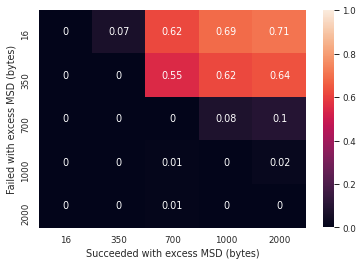

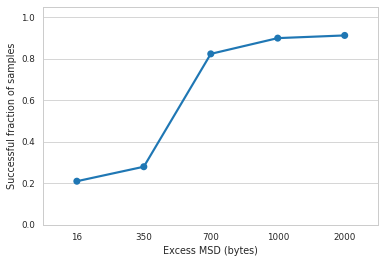

In [6]:
def plot_success_rate(data):
    # Set the required columns as indices and sort
    data = data.set_index(["sample_id", "excess_msd", "rate", "dir", "metric"])[["value"]]
    data = data.sort_index()
    
    # We only need a single sample per sample-id--excess-msd pair, so select 1
    # Use pearsonr since we have some cases where mutual_info did not compute
    data = data.loc[idx[:, :, :, :, "pearsonr"], :]
    data = data.groupby(["sample_id", "excess_msd"]).head(1)
    
    # Determine success by checking if we have a value for the metric
    data["success"] = ~data["value"].isna()
    
    # Select only the relevant columns
    data = data.reset_index()[["sample_id", "excess_msd", "success"]]
    display(data.pivot(index="sample_id", columns="excess_msd").fillna(False).melt(ignore_index=False))
    
    _plot_heatmap(data).savefig(plot_file["heatmap"])
    _plot_trend(data).savefig(plot_file["trend"])
    
plot_success_rate(data)

,sample_id,metric,Direction,excess_msd,value
0,0000_00,Pearson Correlation,in,16,0.937548
2,0000_00,Scaled DTW,in,16,0.245542
4,0000_00,Scaled Euclidean,in,16,0.745259
6,0001_00,Pearson Correlation,in,16,0.035896
8,0001_00,Scaled DTW,in,16,0.653178
...,...,...,...,...,...
6140,0989_00,Scaled DTW,in,2000,1.247766
6142,0989_00,Scaled Euclidean,in,2000,1.290862
6144,0995_00,Pearson Correlation,in,2000,0.441918
6146,0995_00,Scaled DTW,in,2000,0.394094


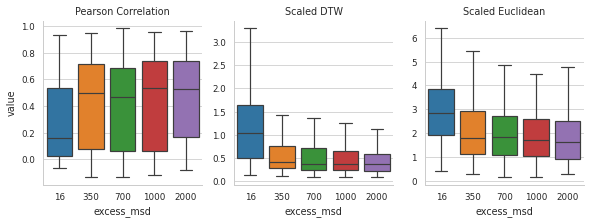

In [17]:
def plot_scores(data):
    # Select a single rate, dropping all rows that failed
    result = data[data["rate"] == "25ms"].drop(columns=["rate", "sample"])
    
    # Pivot to have a column per excess_msd value, and then drop all rows that didnt 
    # succeed across all excess_msd values
    result = result.pivot(index=["sample_id", "metric", "dir"], columns="excess_msd")
    result = result.dropna()
    result = result.droplevel(0, axis=1)
    
    plot_data = result.reset_index().melt(id_vars=["sample_id", "metric", "dir"])
    plot_data = plot_data.rename(columns={"dir": "Direction"})
    plot_data["metric"] = plot_data["metric"].replace({"pearsonr": "Pearson Correlation", "scaled_dtw": "Scaled DTW", "scaled_euclidean": "Scaled Euclidean"})
    plot_data = plot_data[plot_data["Direction"] == "in"]
    display(plot_data)
    
    grid = sns.catplot(data=plot_data, x="excess_msd", y="value", col="metric", sharey=False, kind="box", height=3, aspect=0.9, showfliers=False)
    grid.set_titles("{col_name}")
    return grid
    
plot_scores(data).savefig(plot_file["scores"])